# RSA ANALYSIS OF VISUAL OBJECTS

In [1]:
import os.path as op
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS

import mne
from mne.io import read_raw_fif, concatenate_raws

In [2]:
matplotlib.use('Qt5Agg')
%matplotlib qt

### Define paths and load the data

In [3]:
# define path
sample_data_folder = '/Users/christinadelta/datasets/testing_vizdata'

# define stimulus trigger mapping
fname = op.join(sample_data_folder, 'visual_stimuli.csv')
conds = read_csv(fname)

In [ ]:
conds

### For now we will restrict the number of conditions to 24

we will run the analysis using the human faces and human bodies 

In [4]:
max_trigger = 24
conds = conds[:max_trigger]
conds.values

array([[0, 'human bodypart', 1, 0, 1, 1],
       [1, 'human bodypart', 1, 0, 1, 1],
       [2, 'human bodypart', 1, 0, 1, 1],
       [3, 'human bodypart', 1, 0, 1, 1],
       [4, 'human bodypart', 1, 0, 1, 1],
       [5, 'human bodypart', 1, 0, 1, 1],
       [6, 'human bodypart', 1, 0, 1, 1],
       [7, 'human bodypart', 1, 0, 1, 1],
       [8, 'human bodypart', 1, 0, 1, 1],
       [9, 'human bodypart', 1, 0, 1, 1],
       [10, 'human bodypart', 1, 0, 1, 1],
       [11, 'human bodypart', 1, 0, 1, 1],
       [12, 'human face', 1, 1, 1, 1],
       [13, 'human face', 1, 1, 1, 1],
       [14, 'human face', 1, 1, 1, 1],
       [15, 'human face', 1, 1, 1, 1],
       [16, 'human face', 1, 1, 1, 1],
       [17, 'human face', 1, 1, 1, 1],
       [18, 'human face', 1, 1, 1, 1],
       [19, 'human face', 1, 1, 1, 1],
       [20, 'human face', 1, 1, 1, 1],
       [21, 'human face', 1, 1, 1, 1],
       [22, 'human face', 1, 1, 1, 1],
       [23, 'human face', 1, 1, 1, 1]], dtype=object)

In [6]:
conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)]
    conditions.append('/'.join(map(str, cond_tags)))

conditions

### Make the event_id dictionary

In [7]:
event_id = dict(zip(conditions, conds.trigger + 1))
event_id 

# event_id['0/human bodypart/human/not-face/animal/natural']

{'0/human bodypart/human/not-face/animal/natural': 1,
 '1/human bodypart/human/not-face/animal/natural': 2,
 '2/human bodypart/human/not-face/animal/natural': 3,
 '3/human bodypart/human/not-face/animal/natural': 4,
 '4/human bodypart/human/not-face/animal/natural': 5,
 '5/human bodypart/human/not-face/animal/natural': 6,
 '6/human bodypart/human/not-face/animal/natural': 7,
 '7/human bodypart/human/not-face/animal/natural': 8,
 '8/human bodypart/human/not-face/animal/natural': 9,
 '9/human bodypart/human/not-face/animal/natural': 10,
 '10/human bodypart/human/not-face/animal/natural': 11,
 '11/human bodypart/human/not-face/animal/natural': 12,
 '12/human face/human/face/animal/natural': 13,
 '13/human face/human/face/animal/natural': 14,
 '14/human face/human/face/animal/natural': 15,
 '15/human face/human/face/animal/natural': 16,
 '16/human face/human/face/animal/natural': 17,
 '17/human face/human/face/animal/natural': 18,
 '18/human face/human/face/animal/natural': 19,
 '19/human 

### Load the MEG data

In [25]:
subjects = 1 # 4 for full dataset (use less to speed up computations)
raws = [] # create empty list to store the raws 

In [31]:
for sub in range(subjects):
    this_sub = 'subject_{}'.format(sub+1)
    this_meg = op.join(sample_data_folder, 
                            f'sample_{this_sub}_tsss_mc.fif')
    
    this_raw = read_raw_fif(this_meg, preload=True)
    raws.append(this_raw)

Opening raw data file /Users/christinadelta/datasets/testing_vizdata/sample_subject_1_tsss_mc.fif...
    Range : 1651000 ... 3242999 =   1651.000 ...  3242.999 secs
Ready.
Reading 0 ... 1591999  =      0.000 ...  1591.999 secs...


<ipython-input-31-804f5ebf9b7c>:6: RuntimeWarning: This filename (/Users/christinadelta/datasets/testing_vizdata/sample_subject_1_tsss_mc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  this_raw = read_raw_fif(this_meg, preload=True)
<ipython-input-31-804f5ebf9b7c>:6: DeprecationWarning: The default for on_split_missing is "warn" in 0.22 but will change to "raise" in 0.23, set it explicitly to avoid this message
  this_raw = read_raw_fif(this_meg, preload=True)
<ipython-input-31-804f5ebf9b7c>:6: RuntimeWarning: Split raw file detected but next file /Users/christinadelta/datasets/testing_vizdata/sample_subject_1_tsss_mc.fi-2.fif does not exist. Ensure all files were transferred properly and that split and original files were not manually renamed on disk (split files should be renamed by loading and re-saving with MNE-Python to preserve proper filename linkage).
  

In [32]:
raws

[<Raw | sample_subject_1_tsss_mc.fif, 323 x 1592000 (1592.0 s), ~3.84 GB, data loaded>,
 <Raw | sample_subject_1_tsss_mc.fif, 323 x 1592000 (1592.0 s), ~6.4 MB, data not loaded>,
 <Raw | sample_subject_1_tsss_mc.fif, 323 x 1592000 (1592.0 s), ~3.84 GB, data loaded>]

In [34]:
raw = concatenate_raws(raws)

In [ ]:
raw.info

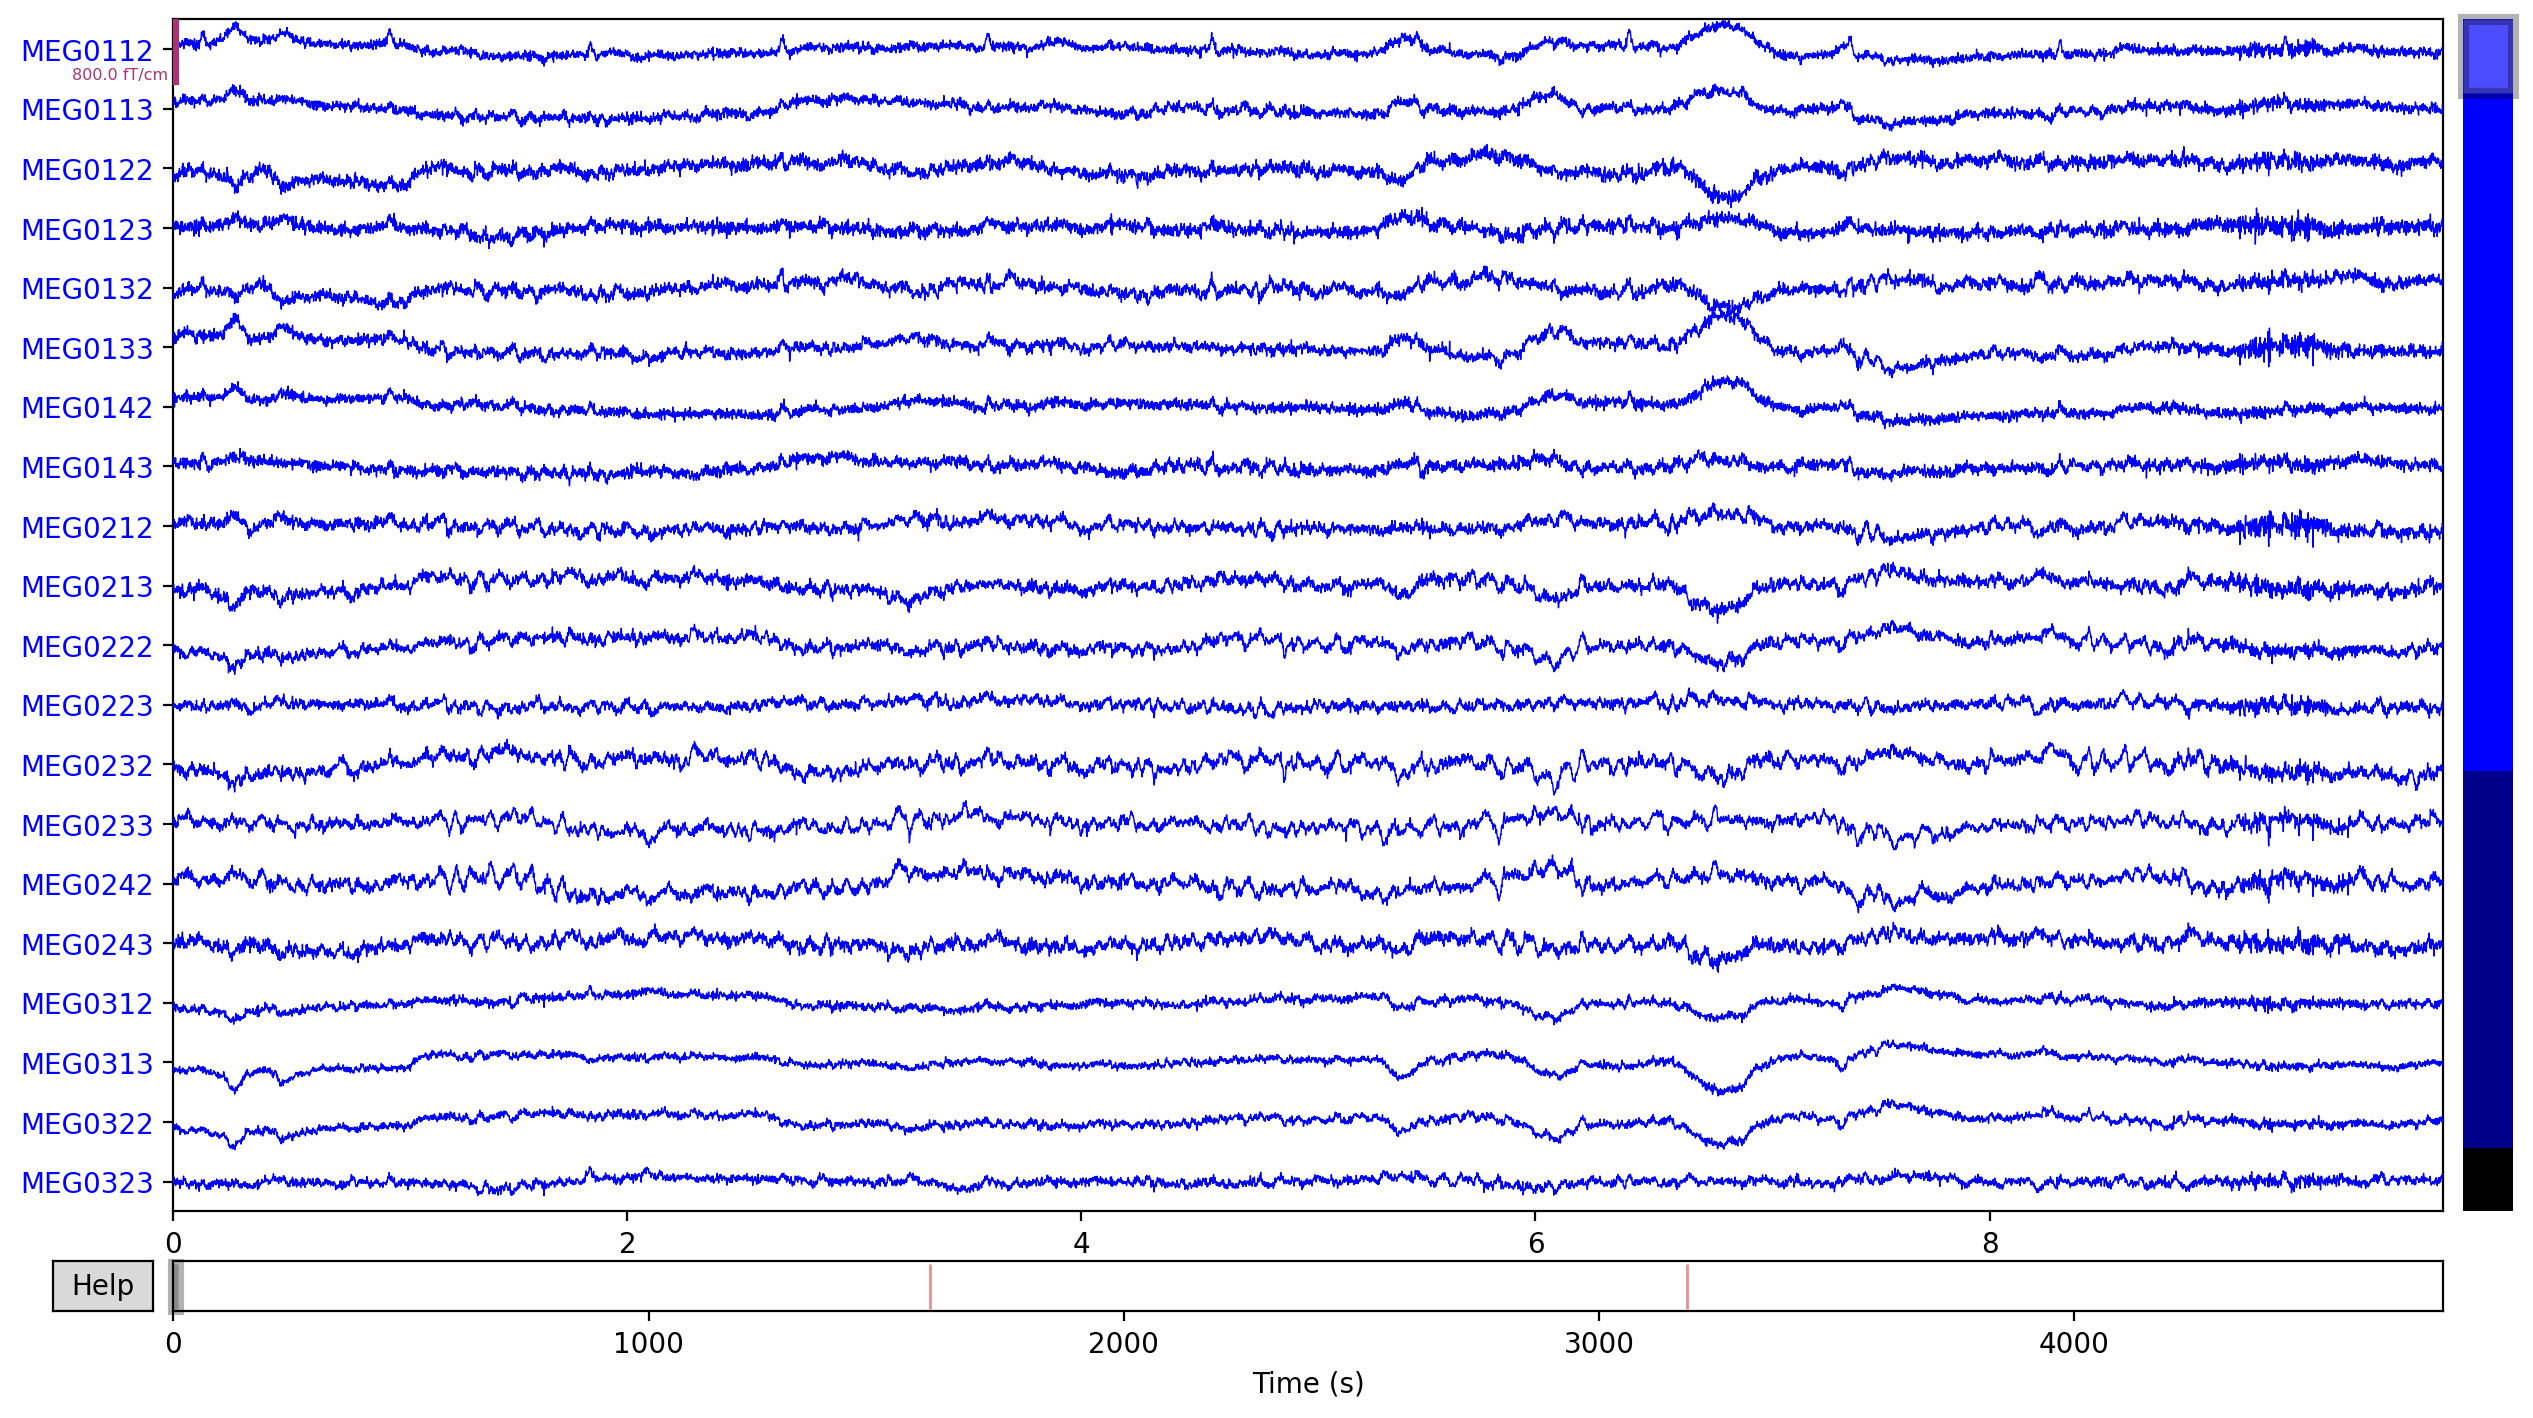

Channels marked as bad: none


In [35]:
raw.plot()

In [ ]:
events = mne.find_events(raw, min_duration=.002)

# keep only events for the 24 first conds 
events = events[events[:, 2] <= max_trigger]
events.shape

### Epoch data

In [ ]:
picks = mne.pick_types(raw.info, meg=True)
epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,
                    picks=picks, tmin=-.1, tmax=.500, preload=True)

In [ ]:
epochs.plot(events=events)

### Plot epochs 

In [ ]:
epochs['face'].average().plot()
epochs['not-face'].average().plot()

## Representational Similarity Analysis

confusion matrix also known as the Representational Dissimilarity Matrix (RDM) 

* the notebook uses multiclass classifier (Multinomial Logistic Regression) 
    * **Pairwise binary classification can also be used**
* Performance metric:ROC-AUC 
    * **Accuracy can also be used to assess performace of the classifier**
* RSA is performed on a time-window of the data
    * **RSA can be computed on each time instant separately**

In [ ]:
# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.
clf = make_pipeline(StandardScaler(),
                    LogisticRegression(C=1, solver='liblinear',
                                       multi_class='auto'))

In [ ]:
X = epochs.copy().get_data().mean(axis=2)

In [ ]:
y = epochs.events[:, 2]
classes = set(y)

In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
cv

In [ ]:
cv.get_n_splits(X, y)

In [ ]:
# Compute confusion matrix for each cross-validation fold
y_pred = np.zeros((len(y), len(classes)))

In [ ]:
for train, test in cv.split(X, y):
    
    print(train, test)
    # Fit
    clf.fit(X[train], y[train])
    # Probabilistic prediction (necessary for ROC-AUC scoring metric)
    y_pred[test] = clf.predict_proba(X[test])

In [ ]:
train.shape, test.shape

In [ ]:
len(classes)

### Compute confusion matrix using ROC-AUC

In [ ]:
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(y == train_class, y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

### Plot

In [ ]:
labels = [''] * 5 + ['face'] + [''] * 11 + ['bodypart'] + [''] * 6
fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha='left')
ax.axhline(11.5, color='k')
ax.axvline(11.5, color='k')
plt.colorbar(im)
plt.tight_layout()
plt.show()

Confusion matrix related to mental representations have been historically summarized with dimensionality reduction using multi-dimensional scaling. See how the face samples cluster together.

In [ ]:
fig, ax = plt.subplots(1)
mds = MDS(2, random_state=0, dissimilarity='precomputed')
chance = 0.5
summary = mds.fit_transform(chance - confusion)
cmap = plt.get_cmap('rainbow')
colors = ['r', 'b']
names = list(conds['condition'].values)
for color, name in zip(colors, set(names)):
    sel = np.where([this_name == name for this_name in names])[0]
    size = 500 if name == 'human face' else 100
    ax.scatter(summary[sel, 0], summary[sel, 1], s=size,
               facecolors=color, label=name, edgecolors='k')
ax.axis('off')
ax.legend(loc='lower right', scatterpoints=1, ncol=2)
plt.tight_layout()
plt.show()